# Libraries to Import

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_style("darkgrid")

DEBUG = True
SEED = 343

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
import itertools

# Load Data

In [20]:
data = pd.read_csv('data/cleaned_data2.csv')
print(data.shape)
data.head()

(2489, 12)


,Method,Path,Body,Single_Q,Double_Q,Dashes,Braces,Slashes,Dots,Asterik,Bad_Words,target
0,GET,/6195b252_3973263ec9bb3e4b938c5c86e3e974cdd8e2...,NaN,0,0,0,0,6,2,0,0,0
1,GET,/v1/jwplayer6/ping.gif?h=2100168025&e=t&n=8063...,NaN,0,0,0,0,3,9,0,0,0
2,GET,/6195b252_3973263ec9bb3e4b938c5c86e3e974cdd8e2...,NaN,0,0,0,0,6,2,0,0,0
3,GET,/6195b252_3973263ec9bb3e4b938c5c86e3e974cdd8e2...,NaN,0,0,0,0,6,2,0,0,0
4,GET,/v1/jwplayer6/ping.gif?h=-1588266826&e=ret&n=1...,NaN,0,0,0,0,3,9,0,0,0


### Feature Selection

### Feature Engineering

In [21]:
data['Directory_Traversal'] = data.apply (lambda row: (row.Dots>=2 and row.Slashes>=1), axis=1)
data.head(1)

,Method,Path,Body,Single_Q,Double_Q,Dashes,Braces,Slashes,Dots,Asterik,Bad_Words,target,Directory_Traversal
0,GET,/6195b252_3973263ec9bb3e4b938c5c86e3e974cdd8e2...,NaN,0,0,0,0,6,2,0,0,0,True


In [22]:
data['No_Quotes'] = data.apply (lambda row: (row.Single_Q==0 and row.Double_Q==0), axis=1)
data.head(1)

,Method,Path,Body,Single_Q,Double_Q,Dashes,Braces,Slashes,Dots,Asterik,Bad_Words,target,Directory_Traversal,No_Quotes
0,GET,/6195b252_3973263ec9bb3e4b938c5c86e3e974cdd8e2...,NaN,0,0,0,0,6,2,0,0,0,True,True


In [23]:
data['Directory_Traversal'] = pd.Categorical(data['Directory_Traversal']).codes
data['No_Quotes'] = pd.Categorical(data['No_Quotes']).codes
data.No_Quotes.value_counts()

1    2158
0     331
Name: No_Quotes, dtype: int64

<AxesSubplot:>

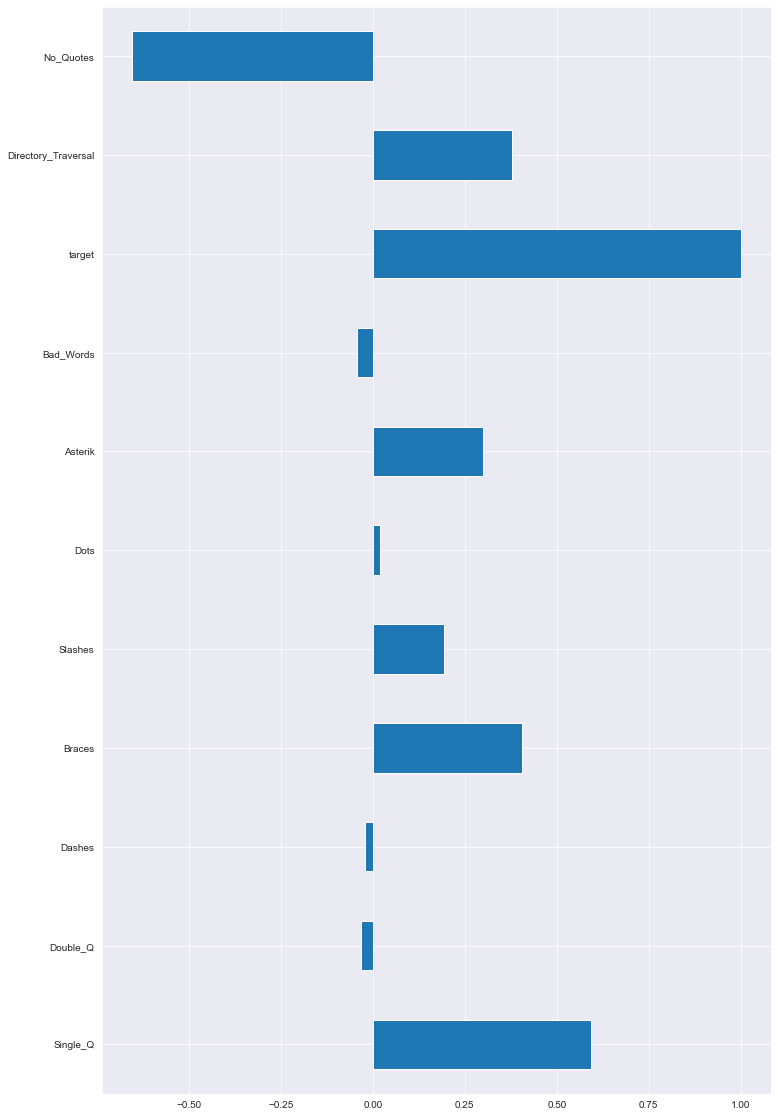

In [24]:
# Plot that shows correlation between target and features
(data.corr().loc['target']
 .plot(kind='barh', figsize=(12,20)))

### Training Data

In [25]:
target = 'target'
features = data.columns.tolist()
for c in [target, 'Method', 'Path', 'Body']:
    features.remove(c)
print(features)

['Single_Q', 'Double_Q', 'Dashes', 'Braces', 'Slashes', 'Dots', 'Asterik', 'Bad_Words', 'Directory_Traversal', 'No_Quotes']


In [26]:
# Splitting data into train and test data
# Split DS into train/test datasets.
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.3,
                                                    random_state=SEED)

In [27]:
tree = DecisionTreeClassifier(random_state=SEED)
forest = RandomForestClassifier(random_state=SEED)
lr = LogisticRegression(random_state=SEED)
knn = KNeighborsClassifier()
svc = SVC(random_state=SEED)
xgboost = XGBClassifier(random_state=SEED)
et = ExtraTreesClassifier(random_state=SEED)

In [28]:
models = [tree, forest, lr, xgboost, et]
if DEBUG:
    for model in models:
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)
        scores = cross_val_score(model, data[features], data[target], scoring='accuracy', cv=cv, n_jobs=-1)
        print(f"The accuracy score of model {type(model).__name__} on the DS is {scores.mean():.4f}")

The accuracy score of model DecisionTreeClassifier on the DS is 0.8998
The accuracy score of model RandomForestClassifier on the DS is 0.9000
The accuracy score of model LogisticRegression on the DS is 0.8988
The accuracy score of model XGBClassifier on the DS is 0.8994
The accuracy score of model ExtraTreesClassifier on the DS is 0.8998


In [29]:
from sklearn.pipeline import Pipeline
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

pipe = Pipeline([
    ('scl', StandardScaler()),
    ('clf', XGBClassifier(n_estimators=500, learning_rate=0.3, max_depth=1, n_jobs=-1,use_label_encoder=False, 
                        eval_metric='logloss', random_state=SEED))
    ])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scl', StandardScaler()),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eval_metric='logloss', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.3, max_delta_step=0, max_depth=1,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=500,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=343, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                               validate_param

### Feature Importance

In [30]:
print("Number of features starting:", len(features))

Number of features starting: 10


In [31]:
rfecv = RFECV(estimator=pipe['clf'], step=1, cv=2, scoring="accuracy", n_jobs=-1)
rfecv.fit(X_train, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 4


In [32]:
features_selected = np.array(features)[rfecv.support_].tolist()
features_selected

['Single_Q', 'Slashes', 'Dots', 'No_Quotes']

In [33]:
print(data.loc[:, features_selected + [target]])

      Single_Q  Slashes  Dots  No_Quotes  target
0            0        6     2          1       0
1            0        3     9          1       0
2            0        6     2          1       0
3            0        6     2          1       0
4            0        3     9          1       0
...        ...      ...   ...        ...     ...
2484         1        5     3          0       1
2485         2       20     5          0       1
2486         2       20     6          0       1
2487         1        5     2          0       1
2488         2       20     5          0       1

[2489 rows x 5 columns]


In [34]:
scores = cross_val_score(estimator=rfecv.estimator, X=data[features_selected], y=data[target], cv=5, n_jobs=-1)
print(scores.mean())

0.8975879372621269


### Evaluation

In [35]:
ss = StandardScaler()

X = ss.fit_transform(data[features].values)
y = data[target].values

X_test = ss.transform(data[features].values)

In [36]:
rfecv.fit(X_train, y_train)
y_pred = rfecv.predict(X_test)

c:\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# cnf_matrix = confusion_matrix(y_test, y_pred)
# np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=['Good', 'Bad'],
                      #title='Confusion matrix, without normalization')

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

* Almost 100% (562/563) of the good requests were correctly predicted
* About 57% of malicious requests were successfully predicted


### Saving trained model to pickle file

In [41]:
# Retrain on entire dataset
rfecv.fit(data[features_selected].values, data[target].values)

RFECV(cv=2,
      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              eval_metric='logloss', gamma=0, gpu_id=-1,
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.3, max_delta_step=0, max_depth=1,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=500,
                              n_jobs=-1, num_parallel_tree=1, predictor='auto',
                              random_state=343, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', use_label_encoder=False,
                              validate_parameters=1, verbosity=None),
      n_jobs=-1, scoring='accuracy')

In [42]:
# Save to pickle file
pd.to_pickle(rfecv, "output/xgb_model.pkl")
